<a href="https://colab.research.google.com/github/WuhaoZ/csci5541_hw1/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tqdm
# !pip install torch
# !pip install transformers
# !pip install datasets
# !pip install -U accelerate
# !pip install -U transformers
# !pip install transformers==4.13.0 accelerate==0.20.1
# !pip install wandb

import time
import math
import torch.nn.functional as F
import csv
from tqdm import tqdm  # Make sure to have this installed: pip install tqdm
import torch
import wandb
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from transformers import Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import TrainingArguments
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoTokenizer
from transformers import AutoModel
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.nn import Dropout
import random
import matplotlib.pyplot as plt

  Using cached wandb-0.16.3-py3-none-any.whl (2.2 MB)
  Using cached GitPython-3.1.41-py3-none-any.whl (196 kB)


In [ ]:
## Import dataset
# dataset = load_dataset("gpt3mix/sst2")

dataset = load_dataset("SetFit/sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# # Define a function for data augmentation
# def augment_example(example):
#     # Implement your data augmentation logic here
#     # Example: Randomly shuffle words in the text
#     text = example["text"].split()
#     random.shuffle(text)
#     augmented_text = " ".join(text)
#     return {"text": augmented_text}

# # Apply data augmentation to the dataset
# dataset = raw_dataset.map(augment_example)

In [ ]:
# def data_collator(batch):
#     input_ids = pad_sequence([torch.tensor(item["input_ids"]) for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
#     attention_mask = pad_sequence([torch.tensor(item["attention_mask"]) for item in batch], batch_first=True, padding_value=0)

#     # No need to convert the label to tensor again
#     labels = torch.tensor([item["label"] for item in batch])

#     return {
#         "input_ids": input_ids,
#         "attention_mask": attention_mask,
#         "labels": labels,
#     }

In [ ]:
# model = AutoModel.from_pretrained("bert-base-cased")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# class CustomTrainer(Trainer):
#   def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
#     number_of_epochs = args.num_train_epochs
#     start = time.time()
#     train_loss = []
#     train_acc = []
#     eval_acc = []
#     criterion = torch.nn.CrossEntropyLoss().to(device)
#     self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
#     self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)
#     # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
#     train_dataloader = self.get_train_dataloader()
#     eval_dataloader = self.get_eval_dataloader()
#     max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))

#     train_result = {'train_loss': [], 'train_acc': [], 'eval_acc': []}

#     for epoch in range(number_of_epochs):
#         train_loss_per_epoch = 0
#         train_acc_per_epoch = 0

#         with tqdm(train_dataloader, unit="batch") as training_epoch:
#             training_epoch.set_description(f"Training Epoch {epoch}")

#             for step, inputs in enumerate(training_epoch):
#                 for key in inputs:
#                     inputs[key] = inputs[key].to(device)
#                 labels = inputs['labels']

#                 self.optimizer.zero_grad()
#                 inputs_for_model = {key: inputs[key].to(device) for key in inputs.keys() if key != 'labels'}
#                 output = model(**inputs_for_model)
#                 # logits = output['pooler_output']

#                 loss = criterion(output["logits"].view(-1, logits.size(-1)), labels.view(-1))
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 self.optimizer.step()

#                 train_loss_per_epoch += loss.item()
#                 train_acc_per_epoch += (logits.argmax(1) == labels).sum().item()

#         train_loss_per_epoch /= len(train_dataloader)
#         train_acc_per_epoch /= (len(train_dataloader) * batch_size)

#         train_result['train_loss'].append(train_loss_per_epoch)
#         train_result['train_acc'].append(train_acc_per_epoch)

#         eval_loss_per_epoch = 0
#         eval_acc_per_epoch = 0

#         with tqdm(eval_dataloader, unit="batch") as eval_epoch:
#             eval_epoch.set_description(f"Evaluation Epoch {epoch}")
#             for step, inputs in enumerate(eval_epoch):
#                 inputs = inputs.to(device)
#                 labels = inputs['labels']

#                 with torch.no_grad():
#                     model.eval()
#                     inputs_for_model = {key: inputs[key].to(device) for key in inputs.keys() if key != 'labels'}
#                     output = model(**inputs_for_model)
#                     logits = output['pooler_output']
#                     model.train()

#                     eval_loss_per_epoch += criterion(logits.view(-1, logits.size(-1)), labels.view(-1)).item()
#                     eval_acc_per_epoch += (logits.argmax(1) == labels).sum().item()

#         eval_loss_per_epoch /= len(eval_dataloader)
#         eval_acc_per_epoch /= (len(eval_dataloader) * batch_size)

#         train_result['eval_acc'].append(eval_acc_per_epoch)
#         # Inside your training loop
#         print(f"Epoch {epoch + 1}: Train Loss: {train_loss_per_epoch}, Train Acc: {train_acc_per_epoch}")


#     print(f'Time: {(time.time() - start) / 60:.3f} minutes ')
#     return train_result

#     print(f'Time: {(time.time() - start) / 60:.3f} minutes ')


In [ ]:
wandb.login()
wandb.init(
  # set the wandb project where this run will be logged
  project="5541_hw1_joseph",

  # track hyperparameters and run metadata
  config={
  "learning_rate": 2e-5,
  "epochs": 3,
  }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zhan7691 (5541). Use `wandb login --relogin` to force relogin


In [ ]:
# Customized _inner_training_loop on epoch level
class CustomTrainer(Trainer):
  def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
    number_of_epochs = args.num_train_epochs
    start = time.time()
    train_loss = []
    train_acc = []
    eval_acc = []
    eval_loss = []

    criterion = torch.nn.CrossEntropyLoss().to(device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.learning_rate)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
    # self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    train_dataloader = self.get_train_dataloader()
    eval_dataloader = self.get_eval_dataloader()
    max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
    train_result = {'train_loss': [], 'eval_loss': [], 'train_acc': [], 'eval_acc': []}

    for epoch in range(number_of_epochs):
      train_loss_per_epoch = 0
      train_acc_per_epoch = 0
      with tqdm(train_dataloader, unit="batch") as training_epoch:
        model.train()
        training_epoch.set_description(f"Training Epoch {epoch}")

        for step, inputs in enumerate(training_epoch):
          inputs = inputs.to(device)
          labels = inputs['labels']

          # Forward pass
          self.optimizer.zero_grad()
          output = self.model(**inputs).logits

          # Calculate the loss
          loss = criterion(output, labels)
          train_loss_per_epoch += loss.item()

          # Calculate gradients
          loss.backward()

          # Update weights
          self.optimizer.step()

          train_acc_per_epoch += (output.argmax(1) == labels).sum().item()

      # Adjust the learning rate
      self.scheduler.step()
      train_loss_per_epoch /= len(train_dataloader)
      train_acc_per_epoch /= (len(train_dataloader) * batch_size)
      # Log train and eval losses
      wandb.log({"train_loss": train_loss_per_epoch, "train_accuracy": train_acc_per_epoch})

      train_result['train_loss'].append(train_loss_per_epoch)
      train_result['train_acc'].append(train_acc_per_epoch)

      eval_loss_per_epoch = 0
      eval_acc_per_epoch = 0
      with torch.no_grad():
        with tqdm(eval_dataloader, unit="batch") as eval_epoch:
          eval_epoch.set_description(f"Evaluation Epoch {epoch}")

          for eval_step, eval_inputs in enumerate(eval_epoch):
            eval_inputs = eval_inputs.to(device)
            eval_labels = eval_inputs['labels']
            model.eval()

            # Forward pass for evaluation
            eval_output = self.model(**eval_inputs).logits
            # Calculate the loss for evaluation
            eval_loss = criterion(eval_output, eval_labels)
            eval_loss_per_epoch += eval_loss.item()

            # Calculate accuracy for evaluation
            eval_acc_per_epoch += (eval_output.argmax(1) == eval_labels).sum().item()

      eval_loss_per_epoch /= len(eval_dataloader)
      eval_acc_per_epoch /= (len(eval_dataloader) * batch_size)
      wandb.log({"eval_loss": eval_loss_per_epoch, "eval_accuracy": eval_acc_per_epoch})
      train_result['eval_acc'].append(eval_acc_per_epoch)
      train_result['eval_loss'].append(eval_loss_per_epoch)

      print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch * 100:.2f}% ')
      print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch * 100:.2f}%')


    print(f'Time: {(time.time() - start) / 60:.3f} minutes')
    return train_result

In [ ]:
training_args = TrainingArguments(
  output_dir='my_awesome_model',
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  num_train_epochs=3,
  weight_decay=0.01,
  evaluation_strategy='epoch',
  save_strategy='epoch',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import random
from datasets import DatasetDict

# Assuming 'tokenized_data' is your DatasetDict
train_dataset = tokenized_data['train']
validation_dataset = tokenized_data['validation']
test_dataset = tokenized_data['test']

# Define the percentage to sample (20%)
subset_percentage = 0.1

# Calculate the number of samples to pick from each set
train_subset_size = int(len(train_dataset) * subset_percentage)
validation_subset_size = int(len(validation_dataset) * subset_percentage)
test_subset_size = int(len(test_dataset) * subset_percentage)

# Randomly sample indices for each set
train_subset_indices = random.sample(range(len(train_dataset)), train_subset_size)
validation_subset_indices = random.sample(range(len(validation_dataset)), validation_subset_size)
test_subset_indices = random.sample(range(len(test_dataset)), test_subset_size)

# Create subset datasets using the sampled indices
train_subset = train_dataset.select(train_subset_indices)
validation_subset = validation_dataset.select(validation_subset_indices)
test_subset = test_dataset.select(test_subset_indices)

# Print the number of samples in each subset
print(f"Number of samples in train subset: {len(train_subset)}")
print(f"Number of samples in validation subset: {len(validation_subset)}")
print(f"Number of samples in test subset: {len(test_subset)}")


Number of samples in train subset: 692
Number of samples in validation subset: 87
Number of samples in test subset: 182


In [ ]:
# Assuming 'tokenized_data' is your DatasetDict
train_dataset = tokenized_data['train']
validation_dataset = tokenized_data['validation']
test_dataset = tokenized_data['test']

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
  predictions, labels = eval_pred.predictions, eval_pred.label_ids
  return {"accuracy": accuracy_score(labels, predictions.argmax(axis=1))}

In [ ]:
customTrainer = CustomTrainer(
  model=model,
  args=training_args,
  train_dataset=train_subset,
  eval_dataset=validation_subset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)
# Train the model
train_result = customTrainer.train()

Training Epoch 0:  23%|██▎       | 5/22 [05:01<17:06, 60.40s/batch]

In [ ]:
# Evaluate on the test_subset
test_result = customTrainer.evaluate(eval_dataset=test_dataset)

print("Test Accuracy:", test_result['eval_accuracy'])

In [ ]:
print(test_result)

In [ ]:
incorrect_predictions = []

# Loop through each example in the test dataset
for example in test_dataset:
    # Tokenize the text and prepare inputs for the model
    inputs = tokenizer(example['text'], return_tensors="pt", max_length=128, truncation=True)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get the raw output logits from the model
    logits = outputs.logits
    # Calculate probabilities using softmax activation
    probabilities = F.softmax(logits, dim=1)

    # Get the class index and label
    predicted_class = torch.argmax(logits, dim=1).item()
    predicted_label = model.config.id2label[predicted_class]

    true_class = example['label']
    true_label = model.config.id2label[true_class]

    # If the predicted class doesn't match the true class, store details
    if predicted_class != true_class:
      incorrect_predictions.append({
        'text': example['text'],
        'predicted_label': predicted_label,
        'true_label': true_label,
        'confidence_score': probabilities[0][predicted_class].item()
      })

# Print the number of incorrectly predicted samples
print("Number of incorrectly predicted samples:", len(incorrect_predictions))

# Save incorrect predictions with confidence scores to a CSV file
csv_file = "incorrect_predictions_with_confidence_scores.csv"
with open(csv_file, 'w', newline='') as file:
  writer = csv.writer(file)

  # Write the header
  writer.writerow(['Text', 'Predicted Label', 'True Label', 'Confidence Score'])

  # Write each incorrect prediction
  for prediction in incorrect_predictions:
    writer.writerow([prediction['text'], prediction['predicted_label'], prediction['true_label'], prediction['confidence_score']])

print("CSV file saved successfully:", csv_file)

In [ ]:
import torch
import torch.nn.functional as F
import csv
import math

# Define a function to calculate entropy
def entropy(probabilities):
    entropy_val = 0
    for prob in probabilities:
        if prob > 0:
            entropy_val += -prob * math.log(prob, 2)
    return entropy_val

incorrect_predictions = []

# Loop through each example in the test dataset
for example in test_dataset:
    # Tokenize the text and prepare inputs for the model
    inputs = tokenizer(example['text'], return_tensors="pt", max_length=128, truncation=True)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get the raw output logits from the model
    logits = outputs.logits
    # Calculate probabilities using softmax activation
    probabilities = F.softmax(logits, dim=1)

    # Get the class index and label
    predicted_class = torch.argmax(logits, dim=1).item()
    predicted_label = model.config.id2label[predicted_class]

    true_class = example['label']
    true_label = model.config.id2label[true_class]

    # If the predicted class doesn't match the true class, store details
    if predicted_class != true_class:
        pos_entropy = entropy(probabilities[0]) if predicted_class == 1 else entropy(1 - probabilities[0])
        neg_entropy = entropy(1 - probabilities[0]) if predicted_class == 1 else entropy(probabilities[0])
        incorrect_predictions.append({
            'text': example['text'],
            'predicted_label': predicted_label,
            'true_label': true_label,
            'confidence_score': probabilities[0][predicted_class].item(),
            'positive_class_entropy': pos_entropy,
            'negative_class_entropy': neg_entropy
        })

# Print the number of incorrectly predicted samples
print("Number of incorrectly predicted samples:", len(incorrect_predictions))

# Save incorrect predictions with confidence scores and entropies to a CSV file
csv_file = "incorrect_predictions_with_confidence_and_entropies.csv"
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Text', 'Predicted Label', 'True Label', 'Confidence Score', 'Positive Class Entropy', 'Negative Class Entropy'])

    # Write each incorrect prediction
    for prediction in incorrect_predictions:
        writer.writerow([prediction['text'], prediction['predicted_label'], prediction['true_label'], prediction['confidence_score'], prediction['positive_class_entropy'], prediction['negative_class_entropy']])

print("CSV file saved successfully:", csv_file)


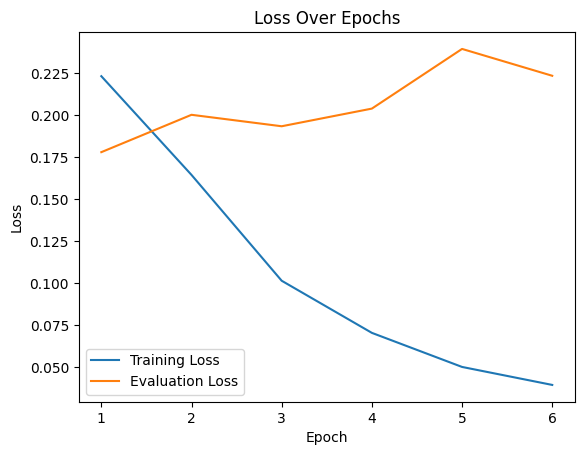

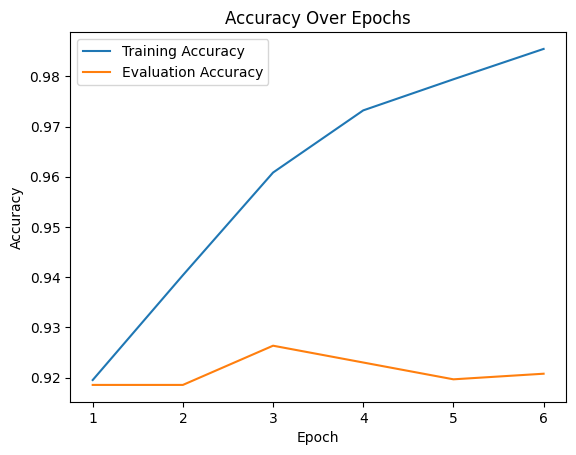

In [ ]:
import matplotlib.pyplot as plt

data = {
    'train_acc': [0.919498848, 0.940380184, 0.960829493, 0.973214286, 0.979406682, 0.985455069],
    'eval_acc': [0.918526786, 0.918526786, 0.926339286, 0.922991071, 0.919642857, 0.920758929],
    'train_loss': [0.223285006917154, 0.164501735150882, 0.101486765412605, 0.0704513907835986, 0.0501615998822303, 0.039456801432129],
    'eval_loss': [0.178047684620001, 0.200295418001977, 0.193471422044759, 0.20398627346315, 0.239519397545206, 0.223531568456175]
}

epochs = range(1, len(data['train_acc']) + 1)

# Plot the loss graph
plt.plot(epochs, data['train_loss'], label='Training Loss')
plt.plot(epochs, data['eval_loss'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy graphs
plt.plot(epochs, data['train_acc'], label='Training Accuracy')
plt.plot(epochs, data['eval_acc'], label='Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


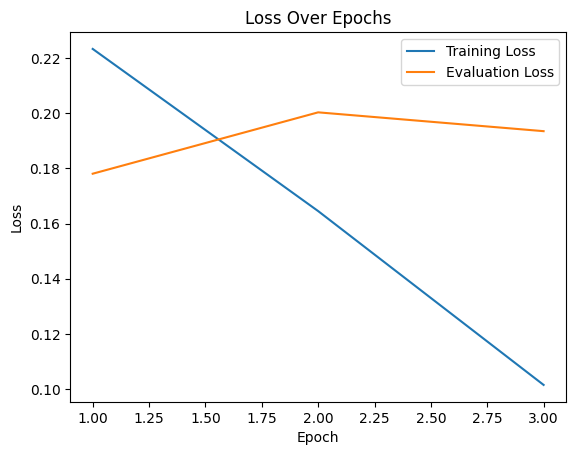

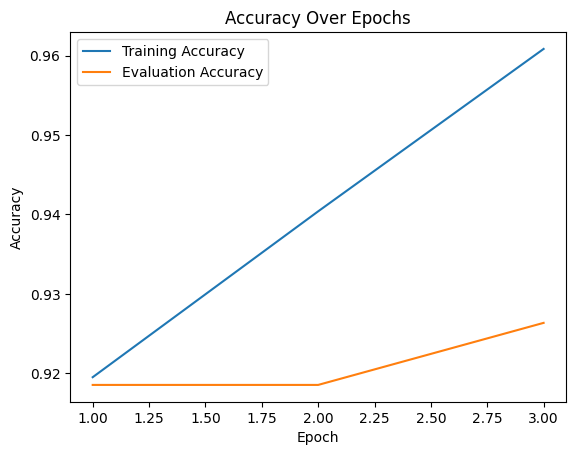

In [ ]:
import matplotlib.pyplot as plt

data = {
    'train_acc': [0.919498848, 0.940380184, 0.960829493],
    'eval_acc': [0.918526786, 0.918526786, 0.926339286],
    'train_loss': [0.223285006917154, 0.164501735150882, 0.101486765412605],
    'eval_loss': [0.178047684620001, 0.200295418001977, 0.193471422044759]
}

epochs = range(1, len(data['train_acc']) + 1)

# Plot the loss graph
plt.plot(epochs, data['train_loss'], label='Training Loss')
plt.plot(epochs, data['eval_loss'], label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy graphs
plt.plot(epochs, data['train_acc'], label='Training Accuracy')
plt.plot(epochs, data['eval_acc'], label='Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()
